# Carregando dados

In [55]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns; sns.set()

df = pd.read_csv('dados.csv')

# Limpeza

### Notação de células vazias

In [56]:
def uniform_missing_values(df, notacoes=['nan', '']):
    obj_cols = df.columns[df.dtypes=='object']
    for col in obj_cols:
        for value in notacoes:
            df[col] = df[col].replace(value, np.nan)
    return df
df = uniform_missing_values(df, notacoes=['nan', ''])

In [ ]:
# Descomente para conferir valores diferentes para notações ou conferir substituição (se já foi feita).
for col in obj_cols+int_cols+float_cols: print(f'{col}: {df[col].unique()}'); print()

# Transformação de Dados

In [103]:
data = df.copy()

# extract columns for each data type
int_cols, obj_cols, float_cols = (
    data.select_dtypes([datatype]).columns.tolist() for datatype in ('int64', 'object', 'float')
)

# import preprocessing functions
from sklearn.preprocessing import LabelEncoder as le, MinMaxScaler as mms

# # Label Encode Categorical Columns
nan_cols = ['CdMarca', 'FlZeroKm', 'CdUfNaturalidade']
for col in obj_cols:
    if col not in nan_cols:
            data[col] = le().fit_transform(data[col].astype(str)) # fill missing values automatically

# Convert ordinal categorical columns tp float
label_cols = ['QTD_SEGURO', 'CdOcupacaoCBO']
data[label_cols] = data[label_cols].astype(float)
            
# Scale Float Columns
data[float_cols+int_cols] = mms().fit_transform(data[float_cols+int_cols]) # eliminates negative values

# fill missing values for float columns
# for col in float_cols:
    # data[col].fillna(data[col].mean(), inplace=True)
#     data[col].fillna(0, inplace=True)

# Exploração

### Análise do uso do app pelo cliente

In [34]:
target = 'fl_renovou'
app_cols = [
    'flmat30conta',
    'flmat60conta',
    'flmat90conta',
    'flmau30conta',
    'flmau60conta',
    'flmau90conta'
]

df['usa_o_app'] = ( df[app_cols].sum(1) > 0 ) + 0

df.groupby([target, 'usa_o_app']).count()['ID'].to_frame('Contagem')

Contagem
fl_renovou usa_o_app          
0          0             32042
           1             16368
1          0              1036
           1               554

In [96]:
a = 554 / (554+1036); a, 1-a

(0.3484276729559748, 0.6515723270440252)

In [97]:
b = 16368 / (16368+32042); b, 1-b

(0.338111960338773, 0.661888039661227)

---
# Análise de perfil do cliente que renova

## Diferença percentual e diferença percentual absoluta da média entre classes

In [151]:
msk = nums[target]==1
nums = data[float_cols+int_cols].copy()
prct_dif = ( nums[msk].mean() - nums.mean() ) / nums.mean()
prct_dif = prct_dif.loc[abs(prct_dif).sort_values(ascending=False).index].drop(target)
abs_dif = abs(prct_dif)

### Dividindo variáveis em intervalos da diferença percentual (ranks de importância)

In [144]:
col_rank = pd.Series(np.zeros(len(abs_dif))+1, index=abs_dif.index)

bins = [1, .75, .5, .25, .15]
for i, lim in enumerate(bins):
    col_rank.loc[abs_dif<lim] = int(i+2)

col_rank.loc[abs_dif.isna()] = np.nan

### Comparando diferença percentual

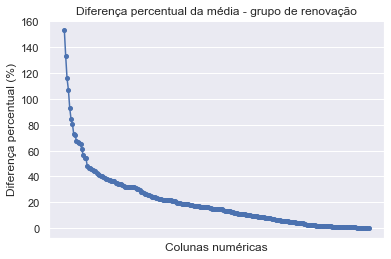

In [145]:
fig, ax = plt.subplots()

(100*abs_dif).plot(ax=ax, marker='o', ms=4,)
ax.set(
    xticks=[], #
    xlabel='Colunas numéricas',
    ylabel='Diferença percentual (%)',
    title='Diferença percentual da média - grupo de renovação',
    # color=list(map(c_map, col_rank.values))
); plt.show()

### Resultado perfil do cliente

#### Análise de duração de ligação 

In [157]:
time = 'Duracao_segundos'
pd.concat([df[msk][time].describe(), df[msk==False][time].describe()], 1)

,Duracao_segundos,Duracao_segundos
count,1098.000000,18571.000000
mean,188.509107,186.088848
std,271.382450,311.925272
min,14.000000,13.000000
25%,68.000000,57.000000
50%,110.000000,91.000000
75%,197.000000,160.000000
max,3207.000000,5462.000000


In [158]:
print('Rank completo: Diferença percentual da média - grupo de renovação'); print()
for i in range(1, 4):
    a = prct_dif[col_rank==i].to_frame(f'Rank {i} - Diferença percentual da média (%)') * 100
    display(a.round(1))

Rank completo: Diferença percentual da média - grupo de renovação



,Rank 1 - Diferença percentual da média (%)
total_ARTIGOS_ESPORTIVOS_F2_m4,153.0
NV_D2_OBJETIVIDADE_3m,133.2
total_ARTIGOS_ESPORTIVOS_F3_m4,115.9
FL_VAREJO_F4,107.2


,Rank 2 - Diferença percentual da média (%)
FL_PET_SHOP_F4,93.0
FL_ARTIGOS_ELETRONICOS_F3,84.1
total_ARTIGOS_ESPORTIVOS_F1_m4,80.6


,Rank 3 - Diferença percentual da média (%)
FL_BEM_ESTAR_F3,72.7
CD_Cartao_6m,71.8
FL_KIDS_F1,67.5
FL_MATERIAL_DE_CONSTRUCAO_F1,67.0
FL_ENTRETENIMENTO_F1,65.8
FL_ARTIGOS_ELETRONICOS_F4,65.0
total_ARTIGOS_ELETRONICOS_F4_m4,61.1
FL_VIAGEM_E_TURISMO_F4,56.3
FL_ELETRODOMESTICO_F2,54.5
total_PET_SHOP_F4_m4,54.1


Conclusões:

1. Renovação à distância de um clique.
2. Em ligação, a oferta só tem uma chance. No aplicativo, a oferta terá presença contínua (Mais oportunidade para o cliente renovar, mais renovação)
3. Clientes que renovam tem duração de chamada acima da média. Isso mostra que os clientes precisam de informação para sentirem segurança e adiquirir a renovação.
    1. É limitidada a quantidade e qualidade de informação que pode ser passada pelo atendente por ligação de voz.
    2. Pelo app, o cliente pode conferir todas as informações da renovação com facilidade.
    3. Além disso, podem ser oferecidas opções, vantagens e personalização, tudo no mesmo lugar.


---
# Código ultrapassado

In [ ]:
#### Carregando dados

import warnings
warnings.filterwarnings('ignore')

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns; sns.set()

from google.cloud.bigquery import Client, QueryJobConfig
client = Client()
query = """SELECT * FROM `hacka-dados.hacka_dados.tabela_dados_hacka`"""
job = client.query(query)
df = job.to_dataframe()

## Limpeza

#### Notação de células vazias

def uniform_missing_values(df, notacoes=['nan', '']):
    obj_cols = df.columns[df.dtypes=='object']
    for col in obj_cols:
        for value in notacoes:
            df[col] = df[col].replace(value, np.nan)
    return df

df = uniform_missing_values(df, notacoes=['nan', ''])

# Descomente para conferir valores diferentes para notações ou conferir substituição (se já foi feita).
# for col in obj_cols: print(f'{col}: {df[col].unique()}'); print()

#### Células vazias e nulas por coluna

empty = df.isna().sum().nlargest(df.shape[1]) / df.shape[0]
null = (df==0).sum().nlargest(df.shape[1]) / df.shape[0]

fig, ax = plt.subplots(figsize=(6, 3.5))
empty.plot()
null.plot() # descomente para incluir valores nulos
(empty+null.loc[empty.index]).plot() # descomente para incluir valores nulos
ax.set(
    xticks=[],
    xlabel='Colunas',
    ylabel='Células (%)',
    title='Células vazias e nulas por coluna (%)',
)
ax.legend(['Vazios (%)', 'Nulos (%)', 'Vazios+Nulos]); plt.show()

null.head(3)

#### Células vazias e nulas por linha

empty = df.isna().sum(1).nlargest(df.shape[0]) / df.shape[1]
null = (df==0).sum(1).nlargest(df.shape[0]) / df.shape[1]

fig, ax = plt.subplots(figsize=(6, 3.5))
ax.plot(np.percentile(empty, range(100)))
ax.plot(np.percentile(null, range(100)))
ax.set(
    xticks=[],
    xlabel='Células (%)',
    ylabel='Linhas (%)',
    title='Percentil vazios/nulos por linha (%/%)',
)
ax.legend(['Vazios (%)', 'Nulos (%) dentre não vazios']); plt.show()

---
## Modelagem preliminar de classificação da renovação

# pessoal não se assuntem, copiei de outro projeto meu pra datasets desbalanceados

### Transformação de dados

data = df.copy()

# extract columns for each data type
int_cols, obj_cols, float_cols = (
    data.select_dtypes([datatype]).columns.tolist() for datatype in ('int64', 'object', 'float')
)

# fill missing values for float columns
for col in float_cols:
    # data[col].fillna(data[col].mean(), inplace=True)
    data[col].fillna(0, inplace=True)

# import preprocessing functions
from sklearn.preprocessing import LabelEncoder as le, MinMaxScaler as mms

#### Label Encode Categorical (+ Integer) Columns
for col in obj_cols + int_cols:
    data[col] = le().fit_transform(data[col]) # fill missing values automatically

#### Scale Float Columns
data[float_cols] = mms().fit_transform(data[float_cols]) # eliminates negative values

### Defina a variável dependente

target = 'fl_renovou'

# define X and Y
Y = data[target].copy()
X = data.drop(target, 1).copy()
    
# target variable classes' count
display(Y.value_counts().rename('Target variable class count').to_frame())

### Under sampling

from módulos.splitter import UnderSampleSplit
from módulos.cv_samplers import print_cls_cnt

uss = UnderSampleSplit(
    train_size=0.8, train_prct=1,
    test_size=0.2, test_prct=None,
    replace=False, shuffle=True,
    random_state=None
)
train_index, test_index = uss.train_test_undersample(Y, random_state=0)
xt, xe, yt, ye = X.loc[train_index], X.loc[test_index], Y.loc[train_index], Y.loc[test_index], 
print_cls_cnt(Y, train_index, test_index)

cv = uss.split(Y, n_splits=10, param_list=None) # under sampling 
# for i in range(5): cv[i] = (cv[i][0], test_index) # to force same test set

left_index = set(Y.index).difference(train_index)

### Modelos e metricas de avaliação

# define model collection
from sklearn.utils import all_estimators
classifiers = dict(all_estimators('classifier'))

#### define score functions
import sklearn.metrics as metrics
recall_0, recall_1 = (metrics.make_scorer(metrics.recall_score, pos_label=label) for label in (0,1))
precision_0, precision_1 = (metrics.make_scorer(metrics.precision_score, pos_label=label) for label in (0,1))
scoring = {
    'accuracy': 'accuracy', 'f1_macro': 'f1_macro',
    'recall_macro': 'recall_macro', 'precision_macro': 'precision_macro',
    'recall_0': recall_0, 'recall_1': recall_1,
    'precision_0': precision_0, 'precision_1': precision_1,
}

### Comparando shuffle splits aleatorios

modelname = 'GradientBoostingClassifier' # 'DecisionTreeClassifier', 'LinearSVC', 'LogisticRegression',
Model = classifiers[modelname]
model = Model(n_estimators=100, random_state=0)

#### score cross validation splits
from sklearn.model_selection import cross_validate
model_scrs = cross_validate(
    model, X, Y, cv=cv,
    scoring=scoring,
    groups=None,
    n_jobs=-1,
    pre_dispatch='all',
    verbose=5
)

scrs_df = pd.DataFrame({scr: model_scrs['test_'+scr] for scr in scoring})
scrs_df.index.name='cv split'

#### Scores médios

scrs_df.agg([np.mean, np.var])#.to_frame('mean').T

#### Scores por split

scrs_df

### Curvas de aprendizado Shuffle splits

from sklearn.model_selection import learning_curve
order=2
train_sizes = np.linspace(0.1, 1, 11)**order
# Calculate recall learning curves per class
lc_0, lc_1 = ( learning_curve(
    model,
    X, Y,
    train_sizes=train_sizes,
    cv=cv,
    scoring=[recall_0, recall_1][i],
    groups=None,
    random_state=0,
    shuffle=True,
    verbose=5,
    n_jobs=-1,
    pre_dispatch='all',
    error_score='raise'
) for i in (0, 1) )

### Plot recall learning curves
for lc_df, cls_label in zip([lc_0, lc_1], ['class 0', 'class 1']):
    train_lc, test_lc = (pd.DataFrame(lc_df[i], index=lc_df[0]) for i in [1,2])
    fig, ax = plt.subplots(1,2, figsize=(9,3), tight_layout=True)
    ax[0].plot(train_lc)
    ax[1].plot(test_lc)
    for i, label in zip([0,1], ['train set', 'test set']):
        ax[i].set(
            title=f'Cross Validation Splits´ Learning Curves - {label}',
            ylabel=f'Recall - {cls_label}',
            xlabel='Train size (nº of samples)'
        )
    plt.show()

---
#### Instalações

!pip install imblearn